# Import Dependencies

In [2]:
from collections import Counter, defaultdict
from functools import partial
import math, random

# Entropy

In [3]:
def entropy(class_probabilities):
    """given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2) for p in class_probabilities if p)

def class_probabilities(labels):
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

def data_entropy(labeled_data):
    labels = [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    return entropy(probabilities)

def partition_entropy(subsets):
    """find the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)

    return sum( data_entropy(subset) * len(subset) / total_count
                for subset in subsets )

def group_by(items, key_fn):
    """returns a defaultdict(list), where each input item
    is in the list whose key is key_fn(item)"""
    groups = defaultdict(list)
    for item in items:
        key = key_fn(item)
        groups[key].append(item)
    return groups

def partition_by(inputs, attribute):
    """returns a dict of inputs partitioned by the attribute
    each input is a pair (attribute_dict, label)"""
    return group_by(inputs, lambda x: x[0][attribute])

def partition_entropy_by(inputs,attribute):
    """computes the entropy corresponding to the given partition"""
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

def classify(tree, input):
    """classify the input using the given decision tree"""

    # if this is a leaf node, return its value
    if tree in [True, False]:
        return tree

    # otherwise find the correct subtree
    attribute, subtree_dict = tree

    subtree_key = input.get(attribute)  # None if input is missing attribute

    if subtree_key not in subtree_dict: # if no subtree for key,
        subtree_key = None              # we'll use the None subtree

    subtree = subtree_dict[subtree_key] # choose the appropriate subtree
    return classify(subtree, input)     # and use it to classify the input

def build_tree_id3(inputs, split_candidates=None):

    # if this is our first pass,
    # all keys of the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()

    # count Trues and Falses in the inputs
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues

    if num_trues == 0:                  # if only Falses are left
        return False                    # return a "False" leaf

    if num_falses == 0:                 # if only Trues are left
        return True                     # return a "True" leaf

    if not split_candidates:            # if no split candidates left
        return num_trues >= num_falses  # return the majority leaf

    # otherwise, split on the best attribute
    best_attribute = min(split_candidates,
        key=partial(partition_entropy_by, inputs))

    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates
                      if a != best_attribute]

    # recursively build the subtrees
    subtrees = { attribute : build_tree_id3(subset, new_candidates)
                 for attribute, subset in partitions.items() }

    subtrees[None] = num_trues > num_falses # default case

    return (best_attribute, subtrees)


In [4]:
inputs = [
    ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
    ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
    ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
    ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
    ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
    ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
    ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
    ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
    ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
    ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
    ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
]

for key in ['level','lang','tweets','phd']:
    print(key, partition_entropy_by(inputs, key))
print()

senior_inputs = [(input, label)
                 for input, label in inputs if input["level"] == "Senior"]

for key in ['lang', 'tweets', 'phd']:
    print(key, partition_entropy_by(senior_inputs, key))
print()

print("building the tree")
tree = build_tree_id3(inputs)
print(tree)

('level', 0.0)
('lang', 0)
('tweets', 0)
('phd', 0)
()
('lang', 0.0)
('tweets', 0.0)
('phd', 0)
()
building the tree
('lang', {'Python': ('tweets', {None: True, 'yes': True, 'no': ('phd', {None: True, 'yes': ('level', {None: False, 'Mid': True, 'Junior': False}), 'no': ('level', {None: True, 'Senior': False, 'Mid': True, 'Junior': True})})}), None: True, 'R': ('tweets', {None: True, 'yes': ('phd', {None: True, 'yes': ('level', {None: False, 'Junior': False, 'Mid': True}), 'no': True})}), 'Java': ('tweets', {None: False, 'yes': True, 'no': False})})


In [5]:

print("Junior / Java / tweets / no phd", classify(tree,
    { "level" : "Junior",
      "lang" : "Java",
      "tweets" : "yes",
      "phd" : "no"} ))

print("Junior / Java / tweets / phd", classify(tree,
    { "level" : "Junior",
             "lang" : "Java",
             "tweets" : "yes",
             "phd" : "yes"} ))

print("Intern", classify(tree, { "level" : "Intern" } ))
print("Senior", classify(tree, { "level" : "Senior" } ))

('Junior / Java / tweets / no phd', True)
('Junior / Java / tweets / phd', True)
('Intern', True)
('Senior', True)


# Random Forests

In [6]:
def forest_classify(trees, input):
    votes = [classify(tree, input) for tree in trees]
    vote_counts = Counter(votes)
    return vote_counts.most_common(1)[0][0]


In [7]:
from sklearn import tree
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [8]:
clf.predict([[2., 2.]])

array([1])

In [9]:
clf.predict_proba([[2., 2.]])

array([[ 0.,  1.]])

In [10]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)

In [12]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

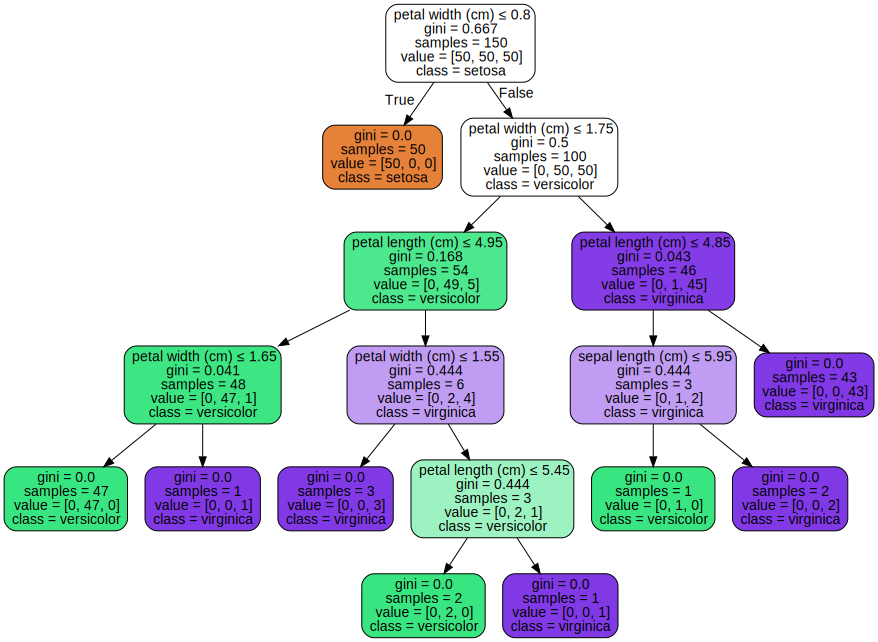

In [13]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data)  
graph

In [14]:
clf.predict(iris.data[:1, :])

array([0])

In [15]:
clf.predict_proba(iris.data[:1, :])

array([[ 1.,  0.,  0.]])